In [1]:
# ------------------------------ IMPORTS ----------------------------------------- #

# Built-in 
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt

# Own Libs
sys.path.append("/home/pablo/Desktop/TuMag/TuMags_Reduction_Pipeline")
import config as cf
from utils import read_Tumag
from field_stop_finder import compute_alignment, apply_fieldstop_and_align_array
from master_dark import compute_master_darks
from master_flatfield import compute_master_flat_field
import image_handler as ih
from demodulation import demodulate
from vlos import cog_profile

In [2]:
MainFolder = "/home/pablo/Desktop/TuMag/ObservationCampaign/2024_07_10_13_00_00_440"
all_files = sorted(glob.glob(f"{MainFolder}/*img")) 

fff_om_1 = "2024_07_10_13_39_36_143_0_1.img"
nims = 5 * 4 * 80

fff_om_1_index = np.where(np.array([os.path.basename(x) for x in all_files]) == fff_om_1)[0][0]
flats_om1  = all_files[fff_om_1_index:fff_om_1_index + 80*5*4]
flats_om2 =  all_files[fff_om_1_index + 80*5*4: fff_om_1_index + 80*5*4 + 8*4*2*5*4]

flats_om1_c1 = [x for x in flats_om1 if "_0_" in x]
flats_om1_c2 = [x for x in flats_om1 if "_1_" in x]

flats_om2_c1 = [x for x in flats_om2 if "_0_" in x]
flats_om2_c2 = [x for x in flats_om2 if "_1_" in x]

Darks = sorted(glob.glob("/home/pablo/Desktop/TuMag/ObservationCampaign/2024_07_10_14_00_00_378/*img"))[:100]
Pinholes = sorted(glob.glob("/home/pablo/Desktop/TuMag/ObservationCampaign/2024_07_10_16_00_01_590/*img"))[:6]


first_mode1 = "2024_07_10_13_16_04_772_0_2.img"
first_index = np.where(np.array([os.path.basename(x) for x in all_files]) == first_mode1)[0][0]

om1_imgs  = all_files[first_index:first_index + 80]


Computing darks ...
N darks for cam1 : 47
N darks for cam2 : 47
Dark current computed in 1.633 s.


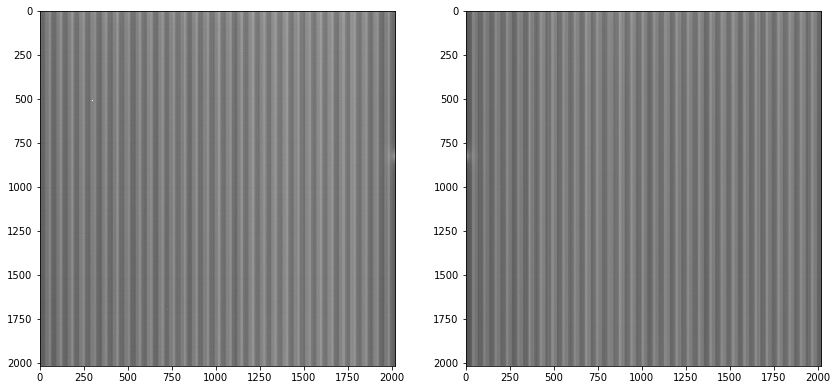

In [3]:
# Darks
dc = compute_master_darks([x for x in Darks[:-6] if "_0_" in x], [x for x in Darks[:-6] if "_1_" in x], verbose = True)
fig, axs = plt.subplots(1, 2, figsize = (14, 7))
axs[0].imshow(dc[0], cmap = 'gray', vmin = np.mean(dc) - np.std(dc), vmax = np.mean(dc) + np.std(dc))
axs[1].imshow(dc[1], cmap = 'gray', vmin = np.mean(dc) - np.std(dc), vmax = np.mean(dc) + np.std(dc))

Computing alignment with pinholes..
Computing correlation...
Finding fieldstop field stop...
[1809, 1810, 1809, 1809, 1810]


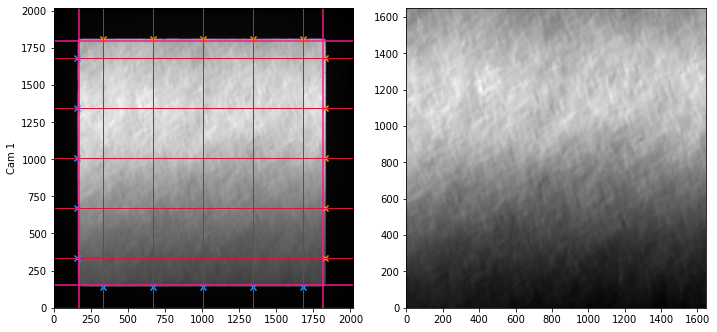

Cam 1 Field stop: [[ 152 1799]
 [ 170 1816]]
Height : 1647
Width : 1646
Field stop computation finished in 0.607s.


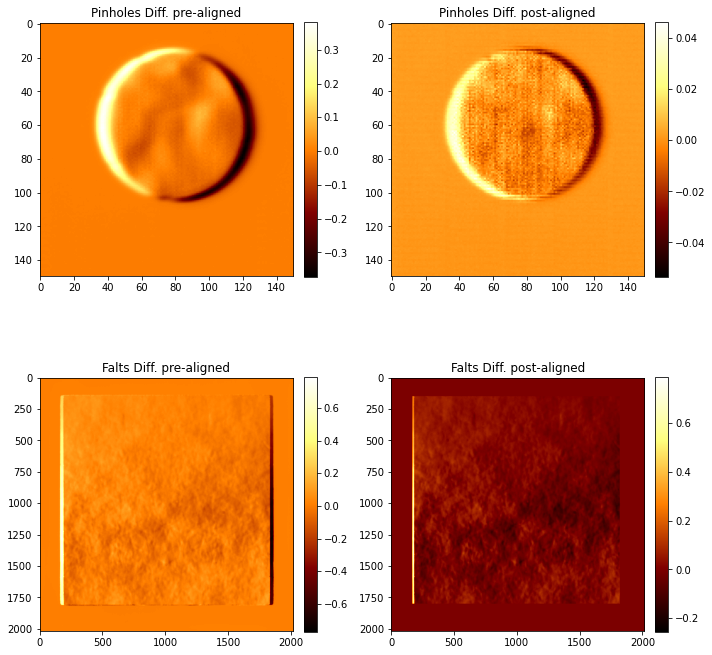

Shift between cameras : X =  -1 - Y - -3 


In [4]:
# Compute alignment
c1, _ = read_Tumag([x for x in flats_om1[:-6] if "_0_" in x][0])
c2, _ = read_Tumag([x for x in flats_om1[:-6] if "_1_" in x][0])
fs_c1, fs_c2 = compute_alignment(flat_cam1=c1 / np.max(c1), flat_cam2= c2 / np.max(c2), pinhole_c1_path=Pinholes[0], pinhole_c2_path=Pinholes[1], method = 'pinhole', plot_flag=True, verbose = True)

In [5]:
ff = compute_master_flat_field(flats_om1, dc = np.zeros((np.shape(dc))), verbose = True)[0]

Computing flats.
N flats: 1600
Observation Mode: 1
Nº of repetitions: 5
Nº of wavelengths: 10
Nº of Modulations: 4
Processing images...
Flat-fields computed in 35.643 s.


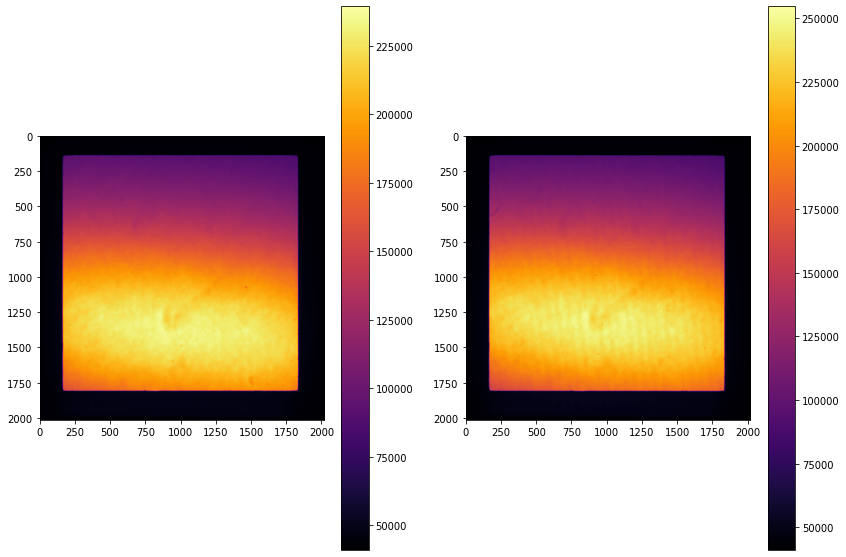

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (14, 10))

im = axs[0].imshow(ff[0,-1, 0], cmap = 'inferno')
im = axs[1].imshow(ff[1,-1, 0], cmap = 'inferno')


In [7]:
ff = apply_fieldstop_and_align_array(ff, fs_c1, fs_c2)

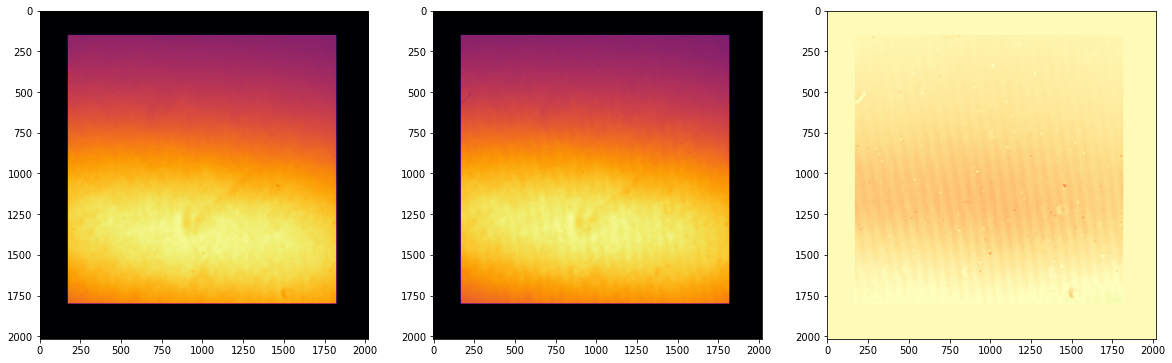

In [17]:
fig, axs = plt.subplots(1, 3, figsize = (20, 10))

im = axs[0].imshow(ff[0,-1, 0], cmap = 'inferno')
im = axs[1].imshow(ff[1,-1, 0], cmap = 'inferno')
im = axs[2].imshow(ff[0,-1, 0] - ff[1,-1, 0], cmap = 'Spectral')

In [19]:
ob = ih.nominal_observation("1", om1_imgs)
data = apply_fieldstop_and_align_array(ob.get_data(), fs_c1, fs_c2)
info = ob.get_info()

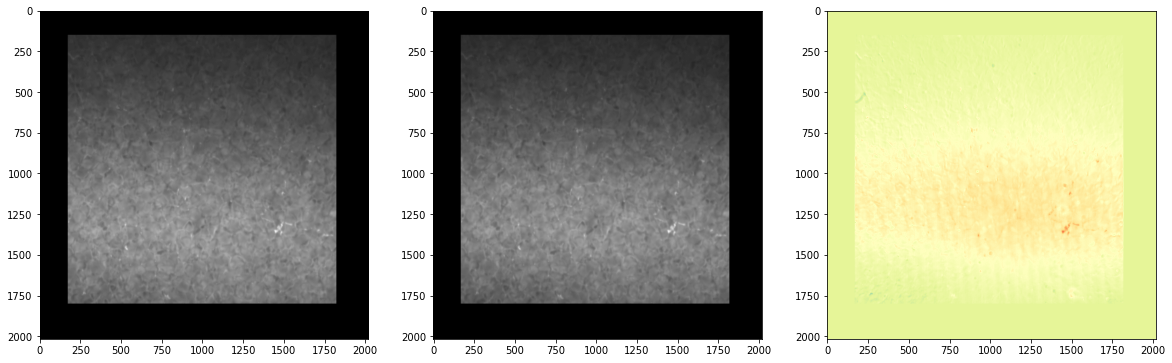

In [16]:
fig, axs = plt.subplots(1, 3, figsize = (20, 10))

im = axs[0].imshow(data[0,-1, 0], cmap = 'gray')
im = axs[1].imshow(data[1,-1, 0], cmap = 'gray')
im = axs[2].imshow(data[0,-1, 0] - data[1,-1, 0], cmap = 'Spectral')

In [21]:
corrected = np.zeros(np.shape(data))

for mod in range(info["Nmods"]):
    for lamb in range(info["Nlambda"]):

        corrected[1, lamb, mod] = (data[0, lamb, mod]) / ff[0, lamb, mod]
        corrected[0, lamb, mod] = (data[1, lamb, mod]) / ff[1, lamb, mod]

/tmp/ipykernel_69642/1122146256.py:6: RuntimeWarning: invalid value encountered in divide
  corrected[1, lamb, mod] = (data[0, lamb, mod]) / ff[0, lamb, mod]
/tmp/ipykernel_69642/1122146256.py:7: RuntimeWarning: invalid value encountered in divide
  corrected[0, lamb, mod] = (data[1, lamb, mod]) / ff[1, lamb, mod]


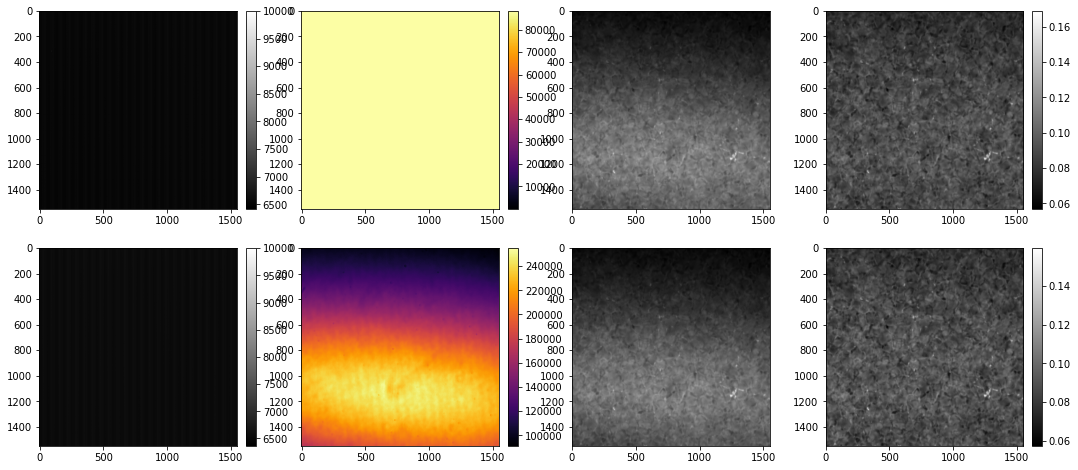

In [22]:
fig, axs = plt.subplots(2, 4, figsize = (18, 8))
im = axs[0, 0].imshow(dc[0, 200:1750, 200:1750], cmap = "gray", vmax = 10000) 
plt.colorbar(im, fraction=0.046, pad=0.04)

im = axs[1, 0].imshow(dc[1, 200:1750, 200:1750], cmap = "gray", vmax = 10000)
plt.colorbar(im, fraction=0.046, pad=0.04)

im = axs[0, 1].imshow(ff[0, -1, 0, 200:1750, 200:1750], cmap = 'inferno', vmax = 1)
plt.colorbar(im, fraction=0.046, pad=0.04)

im = axs[1, 1].imshow(ff[1, -1, 0, 200:1750, 200:1750], cmap = 'inferno')
plt.colorbar(im, fraction=0.046, pad=0.04)

axs[0, 2].imshow(data[0, -1, 0, 200:1750, 200:1750], cmap = "gray")
axs[1, 2].imshow(data[1, -1, 0, 200:1750, 200:1750], cmap = "gray")

im = axs[0, 3].imshow(corrected[0, -1, 0, 200:1750, 200:1750], cmap = "gray")
plt.colorbar(im, fraction=0.046, pad=0.04)

im = axs[1, 3].imshow(corrected[1, -1, 0, 200:1750, 200:1750], cmap = "gray")
plt.colorbar(im, fraction=0.046, pad=0.04)

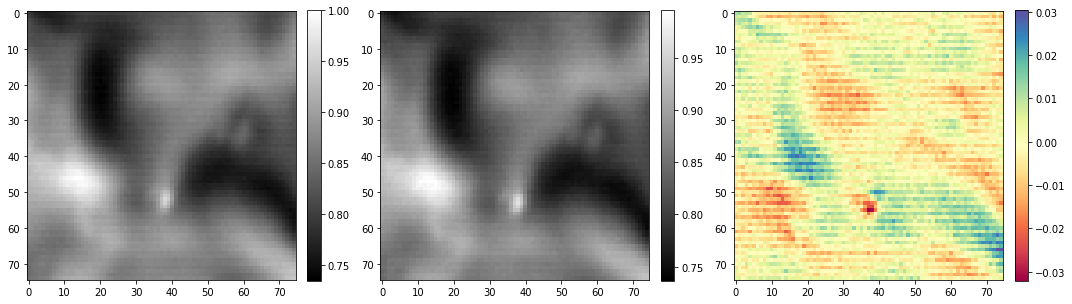

In [29]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

cds_check_x = [950 + 125, 1150] 
cds_check_y = [200, 400 - 125] 

im = axs[0].imshow(corrected[0, -1, 0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]   / np.max(corrected[0, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]), cmap = "gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
im = axs[1].imshow(corrected[1, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]/ np.max(corrected[0, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]), cmap = "gray")
plt.colorbar(im, fraction=0.046, pad=0.04)
im = axs[2].imshow(corrected[0, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]] / np.max(corrected[0, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]) -\
                   corrected[1, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]] / np.max(corrected[1, -1,0, cds_check_x[0]:cds_check_x[1], cds_check_y[0]:cds_check_y[1]]), cmap = "Spectral")
plt.colorbar(im, fraction=0.046, pad=0.04)

plt.tight_layout()

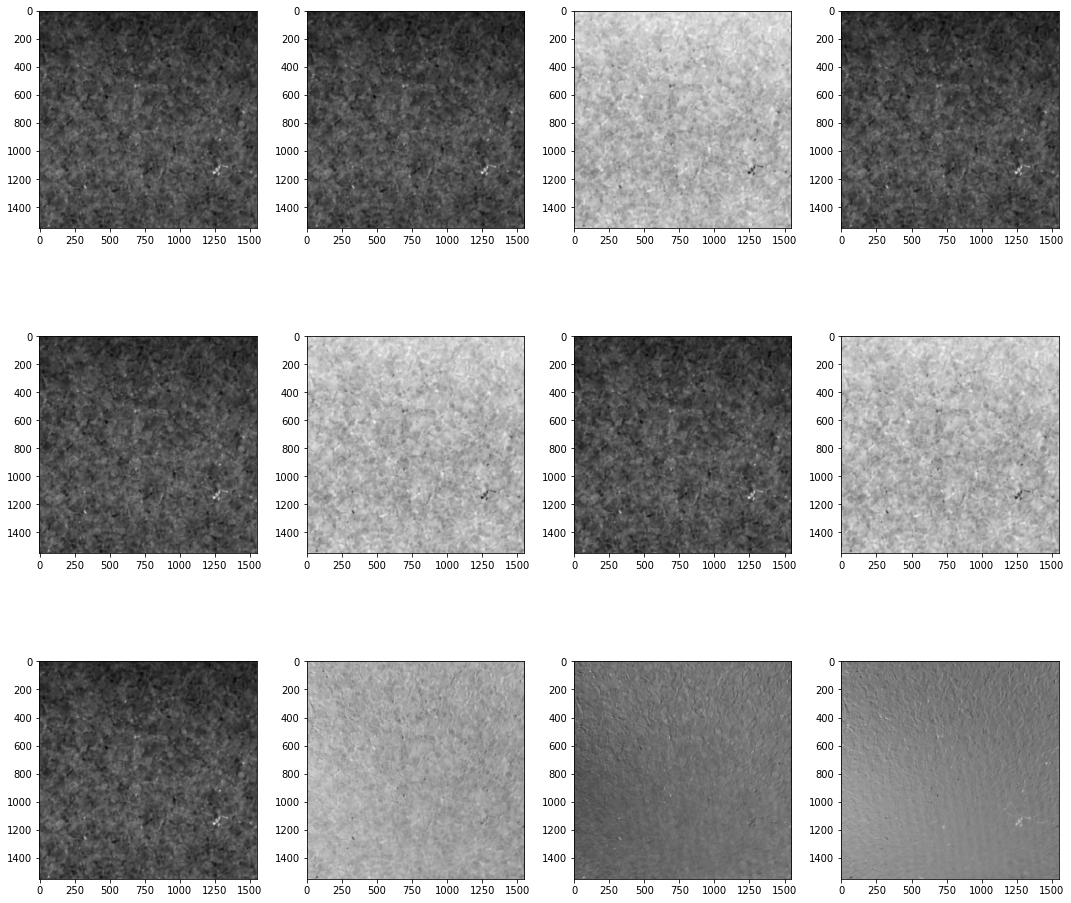

In [27]:
demod, dual = demodulate(corrected[:, -1], 2016, 2016, info["Nmods"], info["Nlambda"], filt = "517", mode = 'standard_single_wavelength') 

fig, axs = plt.subplots(3, 4, figsize = (15, 14))

axs[0, 0].imshow(demod[0, 0, 200:1750, 200:1750], cmap = "gray")
axs[0, 1].imshow(demod[0, 1, 200:1750, 200:1750], cmap = "gray")
axs[0, 2].imshow(demod[0, 2, 200:1750, 200:1750], cmap = "gray")
axs[0, 3].imshow(demod[0, 3, 200:1750, 200:1750], cmap = "gray")

axs[1, 0].imshow(demod[1, 0, 200:1750, 200:1750], cmap = "gray")
axs[1, 1].imshow(demod[1, 1, 200:1750, 200:1750], cmap = "gray")
axs[1, 2].imshow(demod[1, 2, 200:1750, 200:1750], cmap = "gray")
axs[1, 3].imshow(demod[1, 3, 200:1750, 200:1750], cmap = "gray")

axs[2, 0].imshow(dual[0, 200:1750, 200:1750], cmap = "gray")
axs[2, 1].imshow(dual[1, 200:1750, 200:1750], cmap = "gray")
axs[2, 2].imshow(dual[2, 200:1750, 200:1750], cmap = "gray")
axs[2, 3].imshow(dual[3, 200:1750, 200:1750], cmap = "gray")

plt.tight_layout()